# Trabajo Práctico N6. Color

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#Funciones auxiliares

def myplotimg (img,vmin=0,vmax=255,title=None):
  plt.imshow(img,cmap='gray', vmin=vmin, vmax=vmax)
  if title != None:
    plt.title(title)
  plt.axis("off")
  plt.show()
  return

def show_side_by_side(imgs, subtitles = None, title = None, vmin=0, vmax=255, **kwargs):
    fig, axes = plt.subplots(1, len(imgs), **kwargs)
    if len(imgs) == 1:
        axes = [axes]
    if title is not None:
        fig.suptitle(title, y=0.8)
    if subtitles is None:
        subtitles = [None for _ in imgs]
    for ax, img, subtitle in zip(axes, imgs, subtitles):
        if subtitle is not None:
            ax.set_title(subtitle)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), vmin=vmin, vmax=vmax)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

## 1)

In [14]:
def segment_ranges(img, ranges):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    final_mask = np.zeros(img.shape[:-1], dtype=np.uint8)

    for (start, end) in ranges:
        mask = cv2.inRange(hsv, start, end)
        final_mask = cv2.bitwise_or(final_mask, mask)

    return cv2.bitwise_and(img, img, mask=final_mask)

### a)

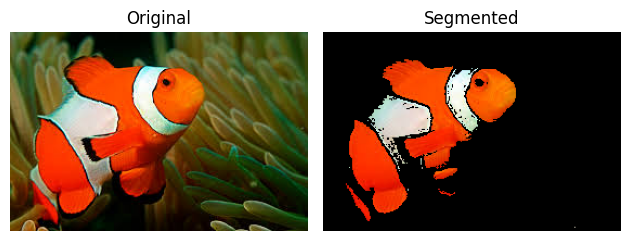

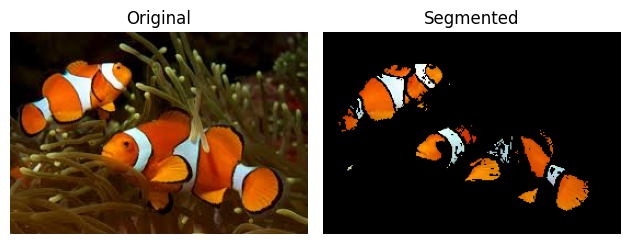

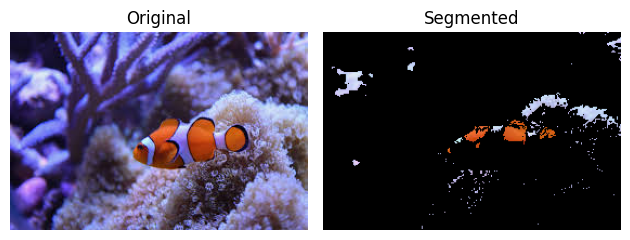

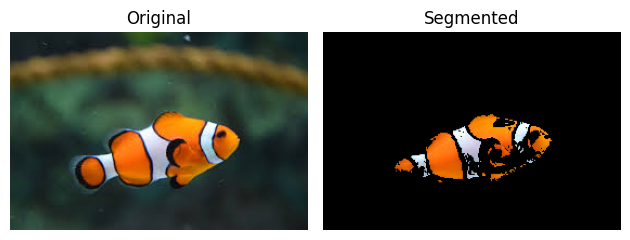

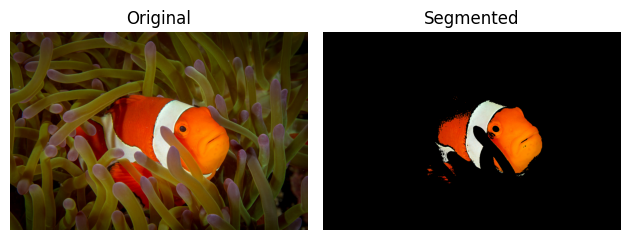

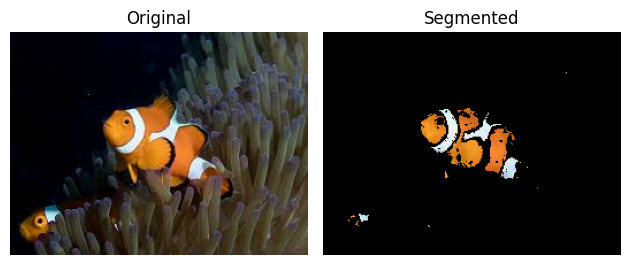

In [15]:
nemo_images = [cv2.imread(f"finding_nemo/images/nemo{n}.jpg") for n in range(6)]

def segment_nemo(img):
    light_orange = (18, 255, 255)
    dark_orange = (1, 190, 200)

    light_white = (145, 60, 255)
    dark_white = (0, 0, 200)

    return segment_ranges(img, ((dark_orange, light_orange), (dark_white, light_white)))

for nemo in nemo_images:
    show_side_by_side([nemo, segment_nemo(nemo)], ["Original", "Segmented"])

La ventaja de usar HSV en vez de RGB se dá en que es mas facil capturar un mismo tono bajo diferentes intensidades de luz al utilizar rangos en HSV.

### b)

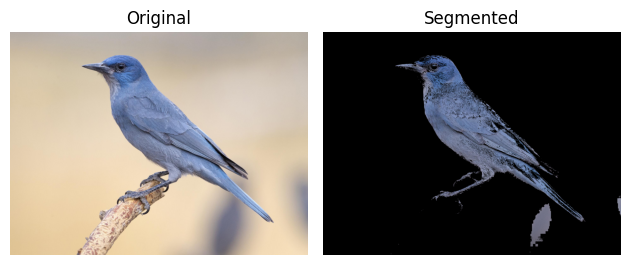

In [16]:
bird = cv2.imread("bird.jpg")

def segment_bird(img):
    dark = (107, 30, 65)
    light = (151, 161, 200)

    return segment_ranges(img, ((dark, light),))

show_side_by_side([bird, segment_bird(bird)], ["Original", "Segmented"])

### c)

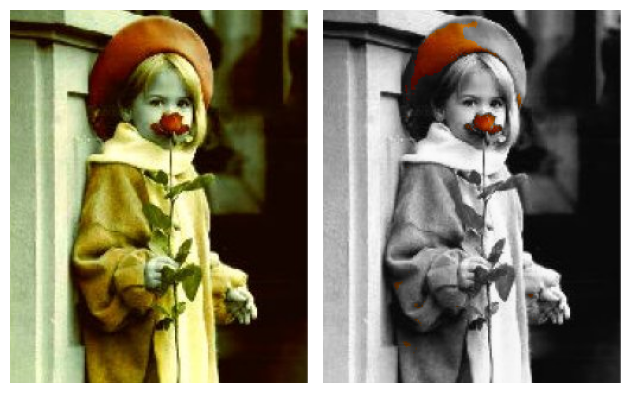

In [17]:
girl = cv2.imread('Girl_and_rose.jpg')
gray_girl = cv2.cvtColor(cv2.cvtColor(girl, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

ranges = [((2, 215, 72),(16, 255, 213) )]

hsv = cv2.cvtColor(girl, cv2.COLOR_BGR2HSV)

rose_mask = np.zeros(girl.shape[:-1], dtype=np.uint8)

for (start, end) in ranges:
    mask = cv2.inRange(hsv, start, end)
    rose_mask = cv2.bitwise_or(rose_mask, mask)
background_mask = cv2.bitwise_not(rose_mask)

filtered_girl = cv2.bitwise_and(girl, girl, mask=rose_mask)
filtered_girl += cv2.bitwise_and(gray_girl, gray_girl, mask=background_mask)

show_side_by_side([girl, filtered_girl])

### d)

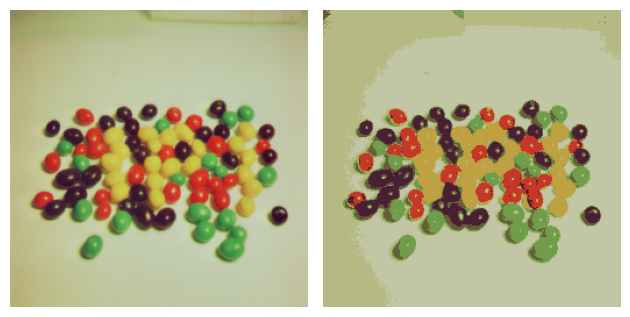

In [18]:
original_image = cv2.imread("beans.tiff")

img=cv2.cvtColor(original_image,cv2.COLOR_BGR2HSV)

vectorized = img.reshape((-1,3))

vectorized = np.float32(vectorized)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 7
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)

res = center[label.flatten()]
result_image = res.reshape((img.shape))
result_image = cv2.cvtColor(result_image, cv2.COLOR_HSV2BGR)

show_side_by_side([original_image, result_image])

## 2)

### a) Investigar que es el filtro de bayer y donde se usa.

El filtro de Bayer es un patrón de filtro de color que se utiliza en los sensores de las camaras digitales. Destras del filtro, se encuentra la matriz de sensores monocromaticos.

Este filtro divide la matriz de pixeles en grupos de cuatro pixeles, y cada grupo consiste de 2 filtros verdes, 1 filtro rojo y 1 filtro azul.

### b) Que es Demosaicing.

De-mosaicing es una tecnica que permite transformar los datos capturados por los sensores que se encuentran detrás de un filtro (generalmente el filtro de bayer) en una imagen de color.

### c) Implementar y explicar el ejemplo del siguiente link: https://cs.brown.edu/courses/csci1290/labs/lab_raw/index.html.

Carga de la imagen

(2638, 3920)


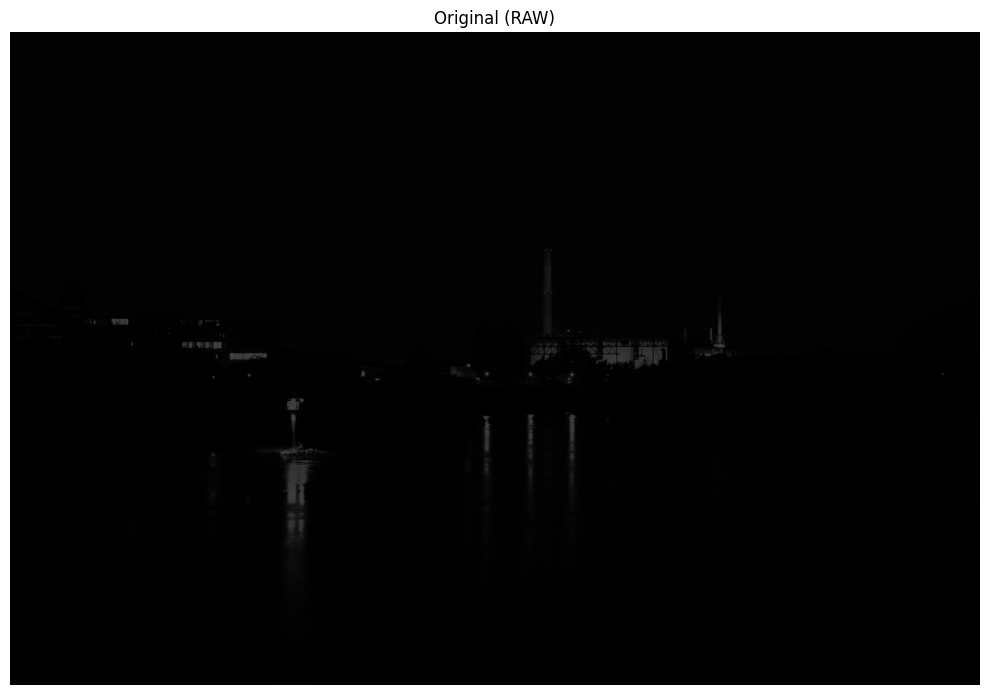

In [19]:
sample = cv2.imread('sample.tiff', cv2.IMREAD_GRAYSCALE)
kwargs = {"figsize": (10, 10)}

print(sample.shape)
show_side_by_side([sample], ["Original (RAW)"], **kwargs)

De-bayering

(1319, 1960)


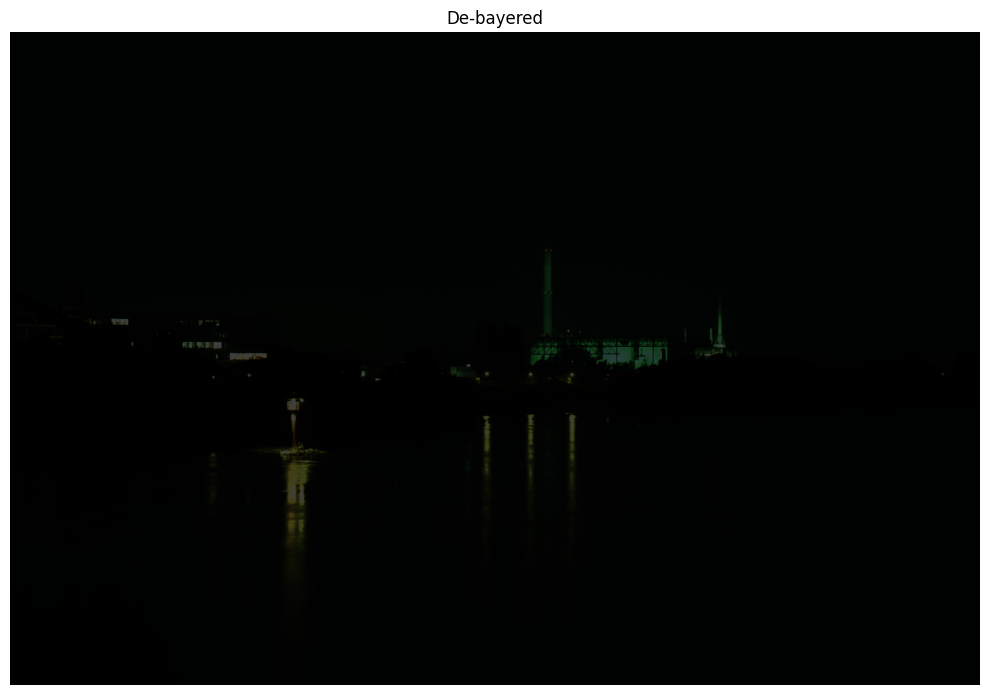

In [20]:
# RGGB
red = sample[0::2, 0::2]
green = (sample[0::2, 1::2] + sample[1::2, 0::2]) / 2
blue = sample[1::2, 1::2]

print(red.shape)
sample_bgr = np.moveaxis(np.array([blue, green, red]), 0, -1).astype(np.float64)

show_side_by_side([np.clip(sample_bgr, 0, 255).astype(np.uint8)], ["De-bayered"], **kwargs)

White Balancing

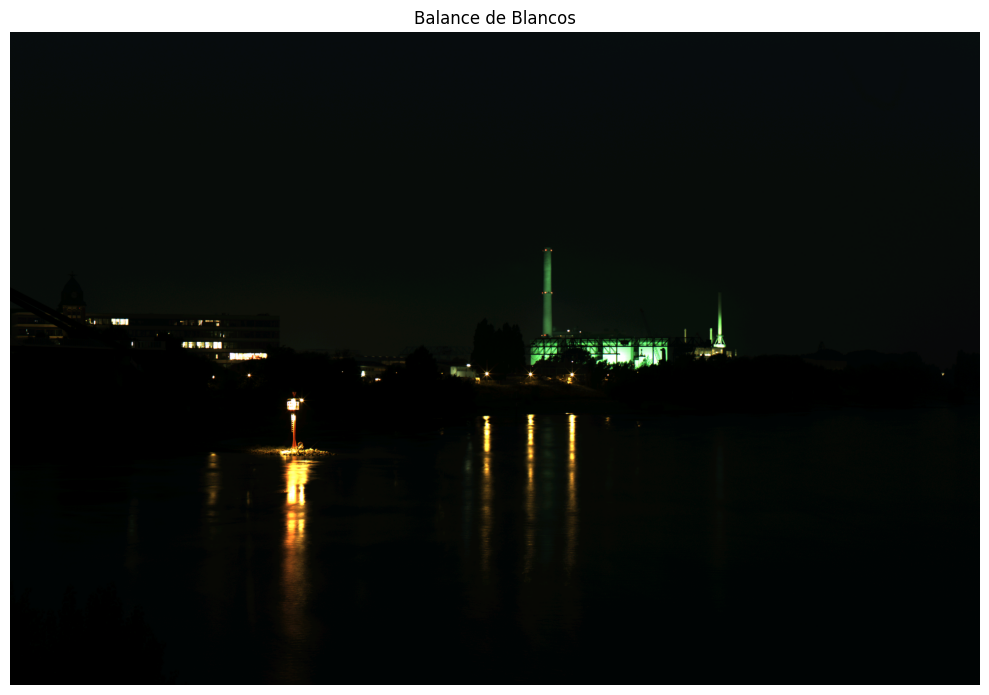

In [21]:
# Ubicacion de un pixel que deberia ser blanco
white_pixel = (1237, 650)
pixel = sample_bgr[white_pixel[1], white_pixel[0], :]
white_balancing = 254 / pixel

for i in range(3):
    sample_bgr[:, :, i] *= white_balancing[i]
sample_bgr = np.clip(sample_bgr, 0, 255)

show_side_by_side([np.clip(sample_bgr, 0, 255).astype(np.uint8)], ["Balance de Blancos"], **kwargs)

Corrección de espacio de color

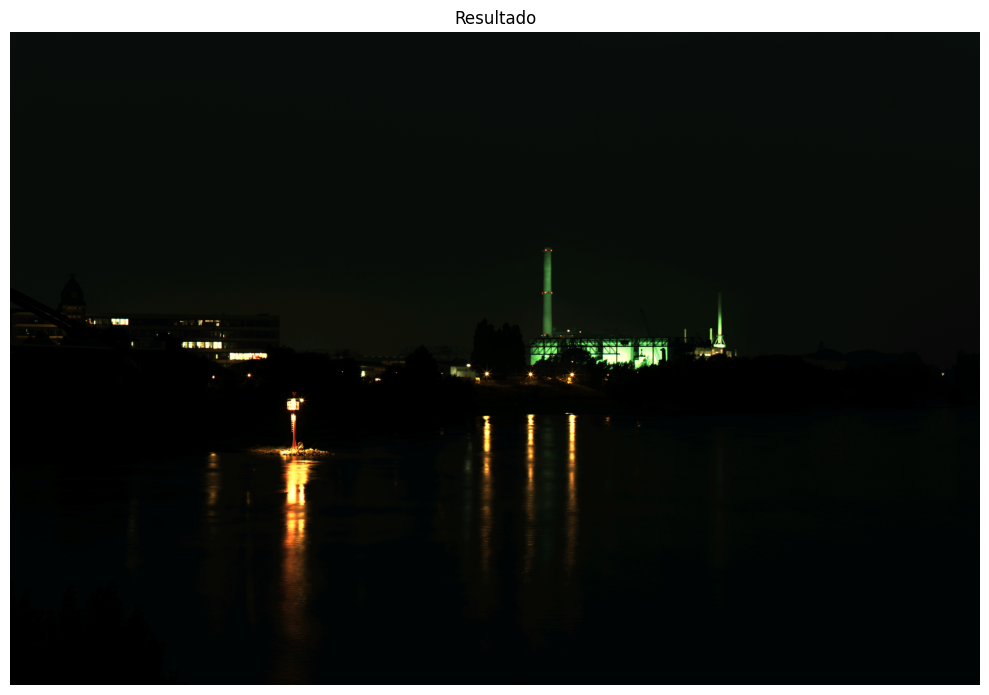

In [22]:
# Valores tomados de la pagina
rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
           [0.2126729, 0.7151522, 0.0721750],
           [0.0193339, 0.1191920, 0.9503041]])
xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
           [-0.4221, 1.3303, 0.0929],
           [-0.0881, 0.2416, 0.7226]])
rgb2cam = xyz2cam * rgb2xyz # Assuming previously defined matrices
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
rgb2cam = np.divide(rgb2cam, denom) # Normalize rows to 1
cam2rgb = np.linalg.inv(rgb2cam)
lin_srgb = sample_bgr @ cam2rgb

show_side_by_side([np.clip(lin_srgb, 0, 255).astype(np.uint8)], ["Resultado"], **kwargs)